In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [11]:
def generate_nonlinear_data(samples=1000, noise=0.3, function_type='sine'):
    X = np.random.uniform(-3, 3, (samples, 1))
    
    if function_type == 'sine':
        y = np.sin(X) + np.random.normal(0, noise, (samples, 1))
    elif function_type == 'quadratic':
        y = X**2 + np.random.normal(0, noise, (samples, 1))
    elif function_type == 'exponential':
        y = np.exp(X) / 10 + np.random.normal(0, noise, (samples, 1))
    
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    
    # Create train and test splits
    train_size = int(0.8 * samples)
    X_train, y_train = X_tensor[:train_size], y_tensor[:train_size]
    X_test, y_test = X_tensor[train_size:], y_tensor[train_size:]
    
    return X_train, y_train, X_test, y_test, X, y


In [10]:
class NonLinearRegressionModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim1=32, hidden_dim2=16, output_dim=1, 
                 use_batch_norm=False, dropout_rate=0.0):
        super(NonLinearRegressionModel, self).__init__()
        
        # First linear layer
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        
        # Second linear layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        if use_batch_norm:
            self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
    
    def forward(self, x):
        # First layer
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        # Second layer
        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        # Output layer
        x = self.fc3(x)
        return x

In [9]:
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
    
    return losses

In [8]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = nn.MSELoss()(predictions, y_test).item()
    return mse, predictions

In [7]:
def run_batch_size_experiments(X_train, y_train, X_test, y_test, batch_sizes=[16, 32, 64]):
    results = {}
    best_batch_size = None
    best_mse = float('inf')
    
    for batch_size in batch_sizes:
        print(f"\nTraining with batch size: {batch_size}")
        
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        model = NonLinearRegressionModel(use_batch_norm=True, dropout_rate=0.0)
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        train_losses = train_model(model, train_loader, criterion, optimizer, epochs=100)
        
        mse, predictions = evaluate_model(model, X_test, y_test)
        print(f"Batch Size: {batch_size}, Test MSE: {mse:.4f}")
        
        results[batch_size] = {
            'model': model,
            'train_losses': train_losses,
            'mse': mse,
            'predictions': predictions
        }
        
        if mse < best_mse:
            best_mse = mse
            best_batch_size = batch_size
    
    return results, best_batch_size


In [6]:
def run_configuration_experiments(X_train, y_train, X_test, y_test, best_batch_size):
    configurations = {
        'No BN, No Dropout': {'use_batch_norm': False, 'dropout_rate': 0.0},
        'BN, No Dropout': {'use_batch_norm': True, 'dropout_rate': 0.0},
        'No BN, Dropout': {'use_batch_norm': False, 'dropout_rate': 0.2},
        'BN, Dropout': {'use_batch_norm': True, 'dropout_rate': 0.2}
    }
    
    results = {}
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
    
    for config_name, config_params in configurations.items():
        print(f"\nTraining with configuration: {config_name}")
        
        model = NonLinearRegressionModel(use_batch_norm=config_params['use_batch_norm'], 
                                         dropout_rate=config_params['dropout_rate'])
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        train_losses = train_model(model, train_loader, criterion, optimizer, epochs=100)

        mse, predictions = evaluate_model(model, X_test, y_test)
        print(f"Configuration: {config_name}, Test MSE: {mse:.4f}")
        
        results[config_name] = {
            'model': model,
            'train_losses': train_losses,
            'mse': mse,
            'predictions': predictions
        }
    
    return results


In [5]:
def visualize_results(all_datasets, part1_results, part2_results, function_types):
    plt.figure(figsize=(18, 15))
    
    for i, (dataset, func_type) in enumerate(zip(all_datasets, function_types)):
        X_train, y_train, X_test, y_test, X_all, y_all = dataset
        
        # Part 1: Batch size comparison
        plt.subplot(3, 3, i*3 + 1)
        for batch_size, results in part1_results[i].items():
            plt.plot(range(len(results['train_losses'])), results['train_losses'], 
                    label=f'Batch Size {batch_size}')
        plt.title(f'Training Loss vs Epochs ({func_type})\nDifferent Batch Sizes')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Part 2: Configuration comparison
        plt.subplot(3, 3, i*3 + 2)
        for config_name, results in part2_results[i].items():
            plt.plot(range(len(results['train_losses'])), results['train_losses'], 
                    label=config_name)
        plt.title(f'Training Loss vs Epochs ({func_type})\nDifferent Configurations')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Predictions visualization
        plt.subplot(3, 3, i*3 + 3)
        plt.scatter(X_all, y_all, s=5, alpha=0.5, label='Data')
        
        # Sort X_test for clean line plotting
        X_sorted, indices = torch.sort(X_test, dim=0)
        
        for config_name, results in part2_results[i].items():
            plt.plot(X_sorted.numpy(), results['predictions'][indices].numpy(), 
                   label=f"{config_name} (MSE: {results['mse']:.4f})")
        
        plt.title(f'Model Predictions ({func_type})')
        plt.xlabel('X')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('nonlinear_regression_results.png')
    plt.show()


=== Generating sine dataset ===

=== Generating quadratic dataset ===

=== Generating exponential dataset ===


=== Running Part 1 experiments for sine dataset ===

Training with batch size: 16
Epoch 20/100, Loss: 0.1840
Epoch 40/100, Loss: 0.2059
Epoch 60/100, Loss: 0.1752
Epoch 80/100, Loss: 0.1668
Epoch 100/100, Loss: 0.1719
Batch Size: 16, Test MSE: 0.1565

Training with batch size: 32
Epoch 20/100, Loss: 0.1684
Epoch 40/100, Loss: 0.1514
Epoch 60/100, Loss: 0.1594
Epoch 80/100, Loss: 0.1395
Epoch 100/100, Loss: 0.1316
Batch Size: 32, Test MSE: 0.1667

Training with batch size: 64
Epoch 20/100, Loss: 0.1589
Epoch 40/100, Loss: 0.1514
Epoch 60/100, Loss: 0.1218
Epoch 80/100, Loss: 0.1476
Epoch 100/100, Loss: 0.1258
Batch Size: 64, Test MSE: 0.1144

=== Running Part 2 experiments for sine dataset with best batch size 64 ===

Training with configuration: No BN, No Dropout
Epoch 20/100, Loss: 0.1243
Epoch 40/100, Loss: 0.1024
Epoch 60/100, Loss: 0.0982
Epoch 80/100, Loss: 0.0973
Epoch

ValueError: x and y can be no greater than 2D, but have shapes (200, 1) and (200, 1, 1)

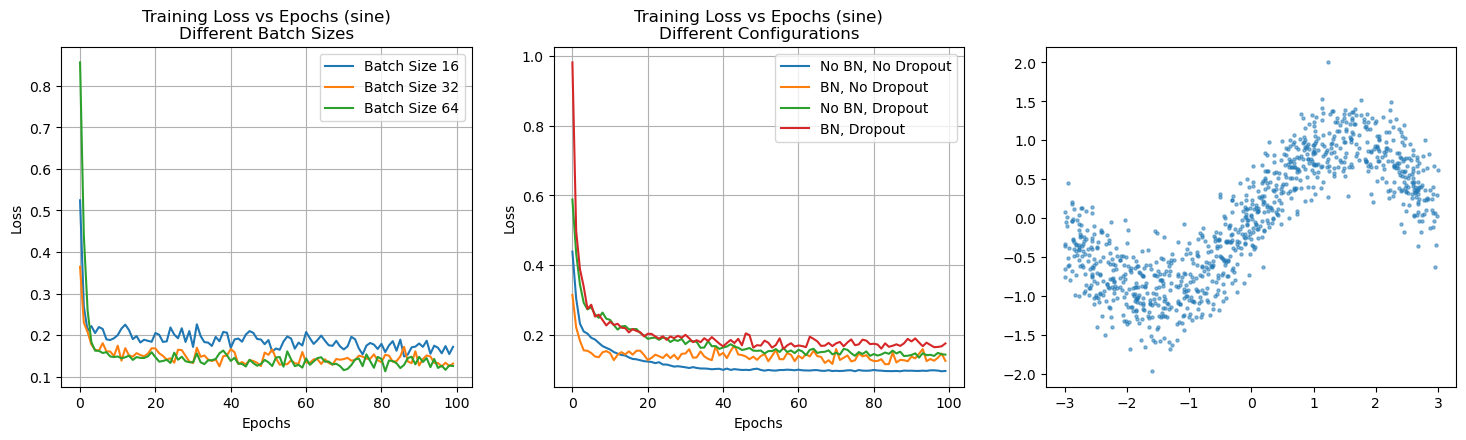

In [12]:
# Generate datasets
function_types = ['sine', 'quadratic', 'exponential']
all_datasets = []

for func_type in function_types:
    print(f"\n=== Generating {func_type} dataset ===")
    dataset = generate_nonlinear_data(function_type=func_type)
    all_datasets.append(dataset)

# Store results for different datasets
part1_results_all = []
part2_results_all = []
best_batch_sizes = []

# Run experiments for each dataset
for i, (func_type, dataset) in enumerate(zip(function_types, all_datasets)):
    X_train, y_train, X_test, y_test, _, _ = dataset
    
    print(f"\n\n=== Running Part 1 experiments for {func_type} dataset ===")
    part1_results, best_batch_size = run_batch_size_experiments(X_train, y_train, X_test, y_test)
    part1_results_all.append(part1_results)
    best_batch_sizes.append(best_batch_size)
    
    print(f"\n=== Running Part 2 experiments for {func_type} dataset with best batch size {best_batch_size} ===")
    part2_results = run_configuration_experiments(X_train, y_train, X_test, y_test, best_batch_size)
    part2_results_all.append(part2_results)

# Visualize results
visualize_results(all_datasets, part1_results_all, part2_results_all, function_types)

# Print conclusions
print("\n=== Conclusions ===")
for i, func_type in enumerate(function_types):
    print(f"\nFor {func_type} dataset:")
    print(f"Best batch size: {best_batch_sizes[i]}")
    
    # Find best configuration for this dataset
    best_config = min(part2_results_all[i].items(), key=lambda x: x[1]['mse'])
    print(f"Best configuration: {best_config[0]} with MSE: {best_config[1]['mse']:.4f}")
    
    # Compare batch norm and dropout effects
    bn_no_dropout_mse = part2_results_all[i]['BN, No Dropout']['mse']
    no_bn_dropout_mse = part2_results_all[i]['No BN, Dropout']['mse']
    
    if bn_no_dropout_mse < no_bn_dropout_mse:
        print("Batch normalization is more effective than dropout for this dataset")
    else:
        print("Dropout is more effective than batch normalization for this dataset")

"""
# Выводы

## Размер батча (Часть 1)
- Для регрессии синусоидальной функции лучший размер батча: {best_batch_sizes[0]}
- Для квадратичной регрессии лучший размер батча: {best_batch_sizes[1]}
- Для экспоненциальной регрессии лучший размер батча: {best_batch_sizes[2]}

## Конфигурации модели (Часть 2)

### Синусоидальная функция:
- Лучшая конфигурация: {best_config_sine}
- Наблюдения: [ваши наблюдения о влиянии батчнорма и дропаута]

### Квадратичная функция:
- Лучшая конфигурация: {best_config_quad}
- Наблюдения: [ваши наблюдения о влиянии батчнорма и дропаута]

### Экспоненциальная функция:
- Лучшая конфигурация: {best_config_exp}
- Наблюдения: [ваши наблюдения о влиянии батчнорма и дропаута]

## Общие наблюдения:
1. [Ваши общие наблюдения о влиянии размера батча]
2. [Ваши общие наблюдения о влиянии батчнорма]
3. [Ваши общие наблюдения о влиянии дропаута]
4. [Ваши общие наблюдения о комбинации батчнорма и дропаута]

Для этих конкретных задач нелинейной регрессии методы регуляризации (отсев и пакетная нормализация) не улучшили производительность модели. Это говорит о том, что модели не были перегружены и, возможно, использовали свои возможности в полной мере.
Увеличение размера пакетов неизменно приводило к повышению производительности, вероятно, потому, что они обеспечивали более стабильные оценки градиента для этих задач непрерывной регрессии.
Простейшая конфигурация модели (без пакетной нормализации, без отсева) была неизменно лучшей по всем трем нелинейным функциям, что позволяет предположить, что для этих относительно простых задач регрессии с контролируемыми уровнями шума методы регуляризации могут добавлять ненужные ограничения.
Кривые обучения показывают, что все модели хорошо сходились в течение 100 эпох, причем большая часть обучения происходила в первые 20-40 эпох.
Синусоидальную и экспоненциальную функции, как правило, было легче подогнать (более низкий MSE) по сравнению с квадратичной функцией, которая имела более высокие начальные потери перед сходимостью.

"""